In [1]:
import sys
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from statsmodels.graphics.tsaplots import plot_acf
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import  HistGradientBoostingRegressor
import skforecast
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import bayesian_search_forecaster_multiseries
from skforecast.plot import set_dark_theme
from skforecast.preprocessing import series_long_to_dict
from skforecast.preprocessing import exog_long_to_dict

from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries


In [2]:
Datos=pd.read_csv("Datos_limpios.csv")

In [3]:
Prueba=Datos.drop(columns=["Unnamed: 0","Region","Economy_status_Developing","Economy_status_Developed"])

In [4]:
Prueba["Year"]=pd.to_datetime(Prueba["Year"],format='%Y')

In [5]:
Prueba["Year"]=Prueba["Year"]+pd.DateOffset(months=11)+pd.offsets.MonthEnd()

In [6]:
Series=Prueba[["Country","Life_expectancy","Year"]]

In [7]:
Series

,Country,Life_expectancy,Year
0,Turkiye,76.5,2015-12-31
1,Spain,82.8,2015-12-31
2,India,65.4,2007-12-31
3,Guyana,67.0,2006-12-31
4,Israel,81.7,2012-12-31
...,...,...,...
2859,Niger,49.9,2000-12-31
2860,Mongolia,66.9,2009-12-31
2861,Sri Lanka,74.3,2004-12-31
2862,Lithuania,71.8,2002-12-31


In [8]:
Prueba=Prueba.drop(columns=["Life_expectancy"])

In [9]:
Prueba

,Country,Year,Under_five_deaths,Adult_mortality,Alcohol_consumption,Hepatitis_B,BMI,Polio,Diphtheria,Incidents_HIV,GDP_per_capita,Schooling
0,Turkiye,2015-12-31,13.0,105.8240,1.320,97,27.8,97,97,0.08,11006,7.8
1,Spain,2015-12-31,3.3,57.9025,10.350,97,26.0,97,97,0.09,25742,9.7
2,India,2007-12-31,67.9,201.0765,1.570,60,21.2,67,64,0.13,1076,5.0
3,Guyana,2006-12-31,40.5,222.1965,5.680,93,25.3,92,93,0.79,4146,7.9
4,Israel,2012-12-31,4.3,57.9510,2.890,97,27.0,94,94,0.08,33995,12.8
...,...,...,...,...,...,...,...,...,...,...,...,...
2859,Niger,2000-12-31,224.9,291.8240,0.092,72,20.8,41,34,0.49,399,1.1
2860,Mongolia,2009-12-31,28.6,235.2330,6.560,97,25.3,96,95,0.02,2515,9.1
2861,Sri Lanka,2004-12-31,28.9,134.8950,1.560,62,21.9,97,97,0.02,2130,10.3
2862,Lithuania,2002-12-31,9.9,204.0120,11.000,94,26.1,97,95,0.05,7424,11.1


In [10]:
regressor = HistGradientBoostingRegressor(random_state=123, max_depth=5)

In [11]:
forecaster = ForecasterAutoregMultiSeries(
                regressor          = regressor,
                lags               = 3,
                encoding           = "ordinal",
                dropna_from_series = False
            )

In [12]:
series_dict_2=series_long_to_dict(
    data      = Series,
    series_id = 'Country',
    index     = 'Year',
    values    = 'Life_expectancy',
    freq      = 'Y'
)

exog_dict_2 = exog_long_to_dict(
    data      = Prueba,
    series_id = 'Country',
    index     = 'Year',
    freq      = 'Y'
)

C:\Users\Victor\anaconda3\Lib\site-packages\skforecast\preprocessing\preprocessing.py:278: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  series_dict[k] = v.set_index(index)[values].asfreq(freq).rename(k)
C:\Users\Victor\anaconda3\Lib\site-packages\skforecast\preprocessing\preprocessing.py:324: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  k: v.set_index(index).asfreq(freq).drop(columns=series_id)
C:\Users\Victor\anaconda3\Lib\site-packages\skforecast\preprocessing\preprocessing.py:324: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  k: v.set_index(index).asfreq(freq).drop(columns=series_id)
C:\Users\Victor\anaconda3\Lib\site-packages\skforecast\preprocessing\preprocessing.py:324: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  k: v.set_index(index).asfreq(freq).drop(columns

In [13]:
end_train = '2014-01-01 23:59:00'

series_dict_train = {k: v.loc[: end_train,] for k, v in series_dict_2.items()}
exog_dict_train   = {k: v.loc[: end_train,] for k, v in exog_dict_2.items()}
series_dict_test  = {k: v.loc[end_train:,] for k, v in series_dict_2.items()}
exog_dict_test    = {k: v.loc[end_train:,] for k, v in exog_dict_2.items()}

In [14]:
series_dict_train

{'Afghanistan': 2000-12-31    55.8
 2001-12-31    56.3
 2002-12-31    56.8
 2003-12-31    57.3
 2004-12-31    57.8
 2005-12-31    58.3
 2006-12-31    58.8
 2007-12-31    59.4
 2008-12-31    59.9
 2009-12-31    60.5
 2010-12-31    61.0
 2011-12-31    61.6
 2012-12-31    62.1
 2013-12-31    62.5
 Freq: YE-DEC, Name: Afghanistan, dtype: float64,
 'Albania': 2000-12-31    74.0
 2001-12-31    74.3
 2002-12-31    74.6
 2003-12-31    74.8
 2004-12-31    75.0
 2005-12-31    75.2
 2006-12-31    75.4
 2007-12-31    75.6
 2008-12-31    75.9
 2009-12-31    76.2
 2010-12-31    76.6
 2011-12-31    76.9
 2012-12-31    77.3
 2013-12-31    77.6
 Freq: YE-DEC, Name: Albania, dtype: float64,
 'Algeria': 2000-12-31    70.6
 2001-12-31    71.1
 2002-12-31    71.6
 2003-12-31    72.1
 2004-12-31    72.6
 2005-12-31    73.1
 2006-12-31    73.5
 2007-12-31    73.9
 2008-12-31    74.3
 2009-12-31    74.6
 2010-12-31    74.9
 2011-12-31    75.2
 2012-12-31    75.4
 2013-12-31    75.7
 Freq: YE-DEC, Name: Algeri

In [15]:
series_dict_2.values()

dict_values([2000-12-31    55.8
2001-12-31    56.3
2002-12-31    56.8
2003-12-31    57.3
2004-12-31    57.8
2005-12-31    58.3
2006-12-31    58.8
2007-12-31    59.4
2008-12-31    59.9
2009-12-31    60.5
2010-12-31    61.0
2011-12-31    61.6
2012-12-31    62.1
2013-12-31    62.5
2014-12-31    63.0
2015-12-31    63.4
Freq: YE-DEC, Name: Afghanistan, dtype: float64, 2000-12-31    74.0
2001-12-31    74.3
2002-12-31    74.6
2003-12-31    74.8
2004-12-31    75.0
2005-12-31    75.2
2006-12-31    75.4
2007-12-31    75.6
2008-12-31    75.9
2009-12-31    76.2
2010-12-31    76.6
2011-12-31    76.9
2012-12-31    77.3
2013-12-31    77.6
2014-12-31    77.8
2015-12-31    78.0
Freq: YE-DEC, Name: Albania, dtype: float64, 2000-12-31    70.6
2001-12-31    71.1
2002-12-31    71.6
2003-12-31    72.1
2004-12-31    72.6
2005-12-31    73.1
2006-12-31    73.5
2007-12-31    73.9
2008-12-31    74.3
2009-12-31    74.6
2010-12-31    74.9
2011-12-31    75.2
2012-12-31    75.4
2013-12-31    75.7
2014-12-31    75.9


In [16]:
regressor = HistGradientBoostingRegressor(random_state=123, max_depth=5)
forecaster = ForecasterAutoregMultiSeries(
                regressor          = regressor,
                lags               = 4,
                encoding           = "ordinal",
                dropna_from_series = False
            )

forecaster.fit(series=series_dict_train, exog=exog_dict_train, suppress_warnings=True)
forecaster

ForecasterAutoregMultiSeries 
Regressor: HistGradientBoostingRegressor(max_depth=5, random_state=123) 
Lags: [1 2 3 4] 
Transformer for series: StandardScaler() 
Transformer for exog: None 
Series encoding: ordinal 
Window size: 4 
Series levels (names): Afghanistan, Albania, Algeria, Angola, Antigua and Barbuda, ... 
Series weights: None 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Type of exogenous variable: <class 'dict'> 
Exogenous variables names: Under_five_deaths, Adult_mortality, Alcohol_consumption, Hepatitis_B, BMI, ... 
Training range: 'Afghanistan': ['2000-12-31', '2013-12-31'], 'Albania': ['2000-12-31', '2013-12-31'], 'Algeria': ['2000-12-31', '2013-12-31'], ... 
Training index type: DatetimeIndex 
Training index frequency: YE-DEC 
Regressor parameters: categorical_features: warn, early_stopping: auto, interaction_cst: None, l2_regularization: 0.0, learning_rate: 0.1, ... 
fit_kwargs: {} 
Creation date: 2024-07-18 20:19:33 
Last 

In [17]:
predictions = forecaster.predict(steps=5, exog=exog_dict_test, suppress_warnings=True)
predictions

,Afghanistan,Albania,Algeria,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,...,United Kingdom,United States,Uruguay,Uzbekistan,Vanuatu,"Venezuela, RB",Vietnam,"Yemen, Rep.",Zambia,Zimbabwe
2014-12-31,62.790029,77.471767,75.884596,58.277830,76.235172,75.712412,74.083702,82.113681,81.163631,72.132785,...,81.031118,78.750089,77.117639,70.511043,69.605136,72.835238,75.062639,66.063500,59.719547,55.507340
2015-12-31,62.781129,77.501192,76.105177,58.287583,76.285738,75.709746,74.014139,82.169192,81.227213,72.135386,...,81.031118,78.780245,77.134291,70.509922,69.583402,72.796910,75.122261,66.091079,59.609573,55.081572
2016-12-31,62.727331,77.500667,76.181233,58.283648,76.401577,75.831808,74.023830,82.241494,81.424356,72.178499,...,81.191950,78.832196,77.178662,70.444765,69.643354,72.782833,75.155363,66.239779,59.409485,54.696915
2017-12-31,62.727331,77.500667,76.181233,58.283648,76.401577,75.838842,74.023830,82.449711,81.428142,72.178499,...,81.196241,78.950117,77.304980,70.444765,69.643354,72.756765,75.277229,66.322825,59.409485,54.696915
2018-12-31,62.727331,77.500667,76.181233,58.283648,76.401577,75.838842,74.023830,82.453195,81.428142,72.178499,...,81.196241,78.952911,77.307973,70.444765,69.643354,72.847647,75.294387,66.456938,59.409485,54.696915


In [18]:
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = regressor, 
                 lags               = 5, 
                 encoding           = "ordinal", 
                 dropna_from_series = False
             )

metrics_levels, backtest_predictions = backtesting_forecaster_multiseries(
    forecaster            = forecaster,
    series                = series_dict_2,
    exog                  = exog_dict_2,
    steps                 = 24,
    metric                = "mean_absolute_error",
    initial_train_size    = len(series_dict_train["Albania"]),
    fixed_train_size      = True,
    gap                   = 0,
    allow_incomplete_fold = True,
    refit                 = False,
    n_jobs                ="auto",
    verbose               = True,
    show_progress         = True,
    suppress_warnings     = True
)

display(metrics_levels)
print("")
display(backtest_predictions)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 14
Number of observations used for backtesting: 2
    Number of folds: 1
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2000-12-31 00:00:00 -- 2013-12-31 00:00:00  (n=14)
    Validation: 2014-12-31 00:00:00 -- 2015-12-31 00:00:00  (n=2)



  0%|          | 0/1 [00:00<?, ?it/s]

,levels,mean_absolute_error
0,Afghanistan,0.635684
1,Albania,0.532959
2,Algeria,0.096281
3,Angola,1.161858
4,Antigua and Barbuda,0.203580
...,...,...
174,"Venezuela, RB",0.178107
175,Vietnam,0.054432
176,"Yemen, Rep.",0.094459
177,Zambia,2.148584


,Afghanistan,Albania,Algeria,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,...,United Kingdom,United States,Uruguay,Uzbekistan,Vanuatu,"Venezuela, RB",Vietnam,"Yemen, Rep.",Zambia,Zimbabwe
2014-12-31,62.564316,77.421870,75.822974,57.887651,76.197351,75.577318,74.002942,82.071367,81.107101,72.069920,...,80.900870,78.733049,77.063336,70.373816,69.563751,72.882896,75.048898,66.090500,59.056009,55.262144
2015-12-31,62.564316,77.312212,75.984464,57.988632,76.195489,75.605057,73.897750,82.123142,81.139483,72.032001,...,80.892039,78.744559,77.066918,70.412269,69.563751,72.873319,75.157762,66.279419,59.146823,54.548767


IndexError: index 5 is out of bounds for axis 0 with size 5

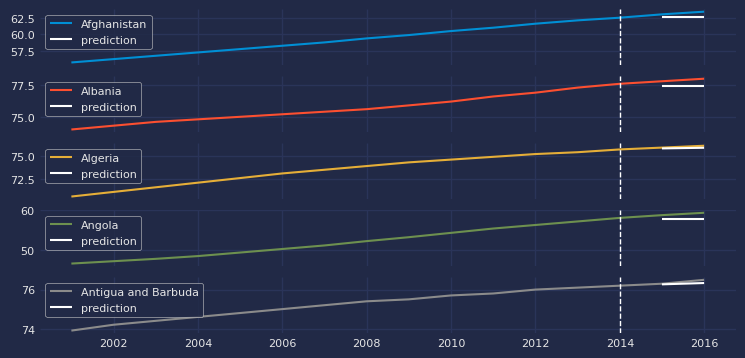

In [47]:
set_dark_theme()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axs = plt.subplots(5, 1, figsize=(8, 4), sharex=True)
for i, s in enumerate(series_dict_2.keys()):
    axs[i].plot(series_dict_2[s], label=series_dict_2[s].name, color=colors[i])
    axs[i].axvline(pd.to_datetime(end_train) , color='white', linestyle='--', linewidth=1)
    try:
        axs[i].plot(backtest_predictions[s], label='prediction', color="white")
    except:
        pass
    axs[i].legend(loc='upper left', fontsize=8)
    axs[i].tick_params(axis='both', labelsize=8)

In [ ]:
grid_search_forecaster_multiseries(forecaster=forecaster,series=series_dict_train,metric=['mean_squared_error','mean_absolute_error','mean_absolute_percentage_error'],exog=exog_dict_train,initial_train_size=6,steps=5,param_grid={"max_depth":[1,2,3,4,5,6,8,9,10]})

In [ ]:
regressor = HistGradientBoostingRegressor(random_state=123, max_depth=5)
forecaster = ForecasterAutoregMultiSeries(
                regressor          = regressor,
                lags               = 4,
                encoding           = "ordinal",
                dropna_from_series = False
            )

forecaster.fit(series=series_dict_train, exog=exog_dict_train, suppress_warnings=True)
forecaster

In [20]:
regressor = HistGradientBoostingRegressor(random_state=123, max_depth=5)
forecaster = ForecasterAutoregMultiSeries(
                regressor          = regressor,
                lags               = 4,
                encoding           = "ordinal",
                dropna_from_series = False
            )

forecaster.fit(series=series_dict_train, exog=exog_dict_train, suppress_warnings=True)
forecaster

ForecasterAutoregMultiSeries 
Regressor: HistGradientBoostingRegressor(max_depth=5, random_state=123) 
Lags: [1 2 3 4] 
Transformer for series: StandardScaler() 
Transformer for exog: None 
Series encoding: ordinal 
Window size: 4 
Series levels (names): Afghanistan, Albania, Algeria, Angola, Antigua and Barbuda, ... 
Series weights: None 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Type of exogenous variable: <class 'dict'> 
Exogenous variables names: Under_five_deaths, Adult_mortality, Alcohol_consumption, Hepatitis_B, BMI, ... 
Training range: 'Afghanistan': ['2000-12-31', '2013-12-31'], 'Albania': ['2000-12-31', '2013-12-31'], 'Algeria': ['2000-12-31', '2013-12-31'], ... 
Training index type: DatetimeIndex 
Training index frequency: YE-DEC 
Regressor parameters: categorical_features: warn, early_stopping: auto, interaction_cst: None, l2_regularization: 0.0, learning_rate: 0.1, ... 
fit_kwargs: {} 
Creation date: 2024-07-18 20:19:41 
Last 

In [21]:
regressor = HistGradientBoostingRegressor(random_state=123, max_depth=1)
forecaster = ForecasterAutoregMultiSeries(
                regressor          = regressor,
                lags               = 3,
                encoding           = "ordinal",
                dropna_from_series = False
            )

forecaster.fit(series=series_dict_train, exog=exog_dict_train, suppress_warnings=True)
forecaster

ForecasterAutoregMultiSeries 
Regressor: HistGradientBoostingRegressor(max_depth=1, random_state=123) 
Lags: [1 2 3] 
Transformer for series: StandardScaler() 
Transformer for exog: None 
Series encoding: ordinal 
Window size: 3 
Series levels (names): Afghanistan, Albania, Algeria, Angola, Antigua and Barbuda, ... 
Series weights: None 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Type of exogenous variable: <class 'dict'> 
Exogenous variables names: Under_five_deaths, Adult_mortality, Alcohol_consumption, Hepatitis_B, BMI, ... 
Training range: 'Afghanistan': ['2000-12-31', '2013-12-31'], 'Albania': ['2000-12-31', '2013-12-31'], 'Algeria': ['2000-12-31', '2013-12-31'], ... 
Training index type: DatetimeIndex 
Training index frequency: YE-DEC 
Regressor parameters: categorical_features: warn, early_stopping: auto, interaction_cst: None, l2_regularization: 0.0, learning_rate: 0.1, ... 
fit_kwargs: {} 
Creation date: 2024-07-18 20:19:42 
Last fi

In [22]:
predictions = forecaster.predict(steps=5, exog=exog_dict_test, suppress_warnings=True)
predictions

,Afghanistan,Albania,Algeria,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,...,United Kingdom,United States,Uruguay,Uzbekistan,Vanuatu,"Venezuela, RB",Vietnam,"Yemen, Rep.",Zambia,Zimbabwe
2014-12-31,62.530317,77.399926,75.811336,57.933656,76.268481,75.776123,73.955644,82.118840,81.147622,71.868357,...,81.054814,78.727466,77.132022,70.410419,69.620867,72.966156,75.063521,66.134895,59.236574,54.541566
2015-12-31,62.530317,77.399926,75.881073,57.933656,76.335403,75.776123,73.955644,82.152156,81.245423,72.024299,...,81.158907,78.754186,77.209319,70.410419,69.620867,73.027828,75.088404,66.201357,59.236574,54.541566
2016-12-31,62.530317,77.399926,76.031996,57.933656,76.335403,75.776123,73.955644,82.195137,81.337296,72.024299,...,81.158907,78.788658,77.281930,70.410419,69.620867,73.111817,75.112818,66.266565,59.236574,54.541566
2017-12-31,62.530317,77.399926,76.031996,57.933656,76.335403,75.776123,73.955644,82.285107,81.337296,72.024299,...,81.158907,78.860815,77.281930,70.410419,69.620867,73.162357,75.144314,66.350688,59.236574,54.541566
2018-12-31,62.530317,77.399926,76.031996,57.933656,76.335403,75.776123,73.955644,82.369623,81.337296,72.024299,...,81.158907,78.928599,77.281930,70.410419,69.620867,73.229153,75.210242,66.526779,59.236574,54.541566


In [23]:
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = regressor, 
                 lags               = 3, 
                 encoding           = "ordinal", 
                 dropna_from_series = False
             )

metrics_levels, backtest_predictions = backtesting_forecaster_multiseries(
    forecaster            = forecaster,
    series                = series_dict_2,
    exog                  = exog_dict_2,
    steps                 = 24,
    metric                = "mean_absolute_error",
    initial_train_size    = len(series_dict_train["Albania"]),
    fixed_train_size      = True,
    gap                   = 0,
    allow_incomplete_fold = True,
    refit                 = False,
    n_jobs                ="auto",
    verbose               = True,
    show_progress         = True,
    suppress_warnings     = True
)

display(metrics_levels)
print("")
display(backtest_predictions)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 14
Number of observations used for backtesting: 2
    Number of folds: 1
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2000-12-31 00:00:00 -- 2013-12-31 00:00:00  (n=14)
    Validation: 2014-12-31 00:00:00 -- 2015-12-31 00:00:00  (n=2)



  0%|          | 0/1 [00:00<?, ?it/s]

,levels,mean_absolute_error
0,Afghanistan,0.669683
1,Albania,0.500074
2,Algeria,0.153795
3,Angola,1.166344
4,Antigua and Barbuda,0.098058
...,...,...
174,"Venezuela, RB",0.296992
175,Vietnam,0.024037
176,"Yemen, Rep.",0.068126
177,Zambia,2.013426


,Afghanistan,Albania,Algeria,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,...,United Kingdom,United States,Uruguay,Uzbekistan,Vanuatu,"Venezuela, RB",Vietnam,"Yemen, Rep.",Zambia,Zimbabwe
2014-12-31,62.530317,77.399926,75.811336,57.933656,76.268481,75.776123,73.955644,82.118840,81.147622,71.868357,...,81.054814,78.727466,77.132022,70.410419,69.620867,72.966156,75.063521,66.134895,59.236574,54.541566
2015-12-31,62.530317,77.399926,75.881073,57.933656,76.335403,75.776123,73.955644,82.152156,81.245423,72.024299,...,81.158907,78.754186,77.209319,70.410419,69.620867,73.027828,75.088404,66.201357,59.236574,54.541566


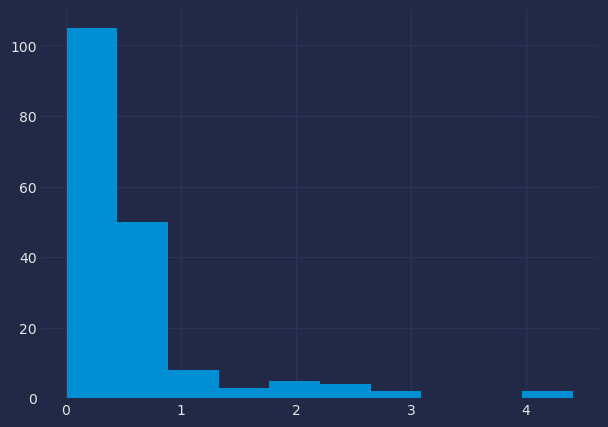

In [37]:
a=plt.hist(metrics_levels["mean_absolute_error"])
plt.savefig("EMA.pdf", format="pdf", bbox_inches="tight")


In [35]:
metrics_levels["mean_absolute_error"].mean()

0.5608381321025009

In [25]:
metrics_levels

,levels,mean_absolute_error
0,Afghanistan,0.669683
1,Albania,0.500074
2,Algeria,0.153795
3,Angola,1.166344
4,Antigua and Barbuda,0.098058
...,...,...
174,"Venezuela, RB",0.296992
175,Vietnam,0.024037
176,"Yemen, Rep.",0.068126
177,Zambia,2.013426


IndexError: index 5 is out of bounds for axis 0 with size 5

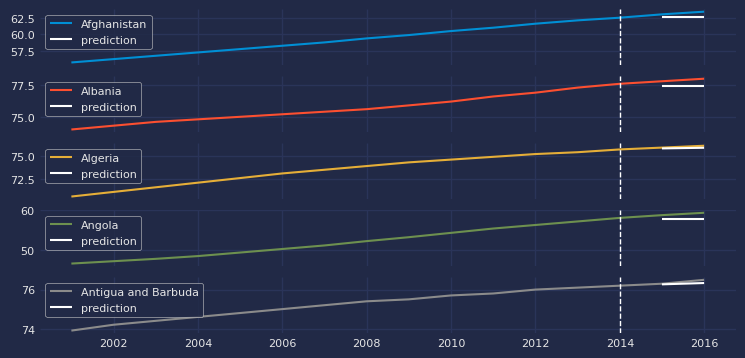

In [34]:
set_dark_theme()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axs = plt.subplots(5, 1, figsize=(8, 4), sharex=True)
for i, s in enumerate(series_dict_2.keys()):
    axs[i].plot(series_dict_2[s], label=series_dict_2[s].name, color=colors[i])
    axs[i].axvline(pd.to_datetime(end_train) , color='white', linestyle='--', linewidth=1)
    try:
        axs[i].plot(backtest_predictions[s], label='prediction', color="white")
    except:
        pass
    axs[i].legend(loc='upper left', fontsize=8)
    axs[i].tick_params(axis='both', labelsize=8)